In [1]:
def rotations(t):
 ''' Return list of rotations of input string t '''
 tt = t * 2 #duplicate string
 return [ tt[i:i+len(t)] for i in range(0, len(t)) ]
def bwm(t):
 ''' Return lexicographically sorted list of t’s rotations '''
 return sorted(rotations(t))
def bwtViaBwm(t):
 ''' Given T, returns BWT(T) by way of the BWM '''
 return ''.join(map(lambda x: x[-1], bwm(t))) #takes last column


In [2]:
def rankBwt(bw):
     ''' Given BWT string bw, return parallel list of B-ranks. Also
     returns tots: map from character to # times it appears. '''
     tots = dict() #na kraju koliko ima ukupno kojih karaktera
     ranks = [] #do tog trenutka, ne cuva karakter samo rank
     for c in bw:
         if c not in tots: tots[c] = 0
         ranks.append(tots[c])
         tots[c] += 1
     return ranks, tots 

In [3]:
def lastCol(bw):
    ranks,tots=rankBwt(bw)
    return list(zip(ranks,bw))  # characters of BWT(T) in order, along with rank

In [4]:
def firstCol(tots):
     ''' Return map from character to the range of rows prefixed by
     the character. '''
     first = {}
     totc = 0
     for c, count in sorted(tots.items()):
         first[c] = totc #changed, it was (totc, totc + count), but we need only first (starting) index
         totc += count
     return first


In [5]:
def reverseBwt(bw):
     ''' Make T from BWT(T) '''
     ranks, tots = rankBwt(bw)
     first = firstCol(tots)
     rowi = 0 # start in first row
     t = '$' # start with rightmost character
     while bw[rowi] != '$':
         c = bw[rowi]
         t = c + t #append to the beggining of the string, so it will be reversed
         # jump to row that starts with c of same rank
         rowi = first[c] + ranks[rowi] #starting column with char c + rank of char c from T
     return t


In [6]:
# BTW via sufix array
def suffixArray(s):
# Take all sufix and sort, while preserving index(offset) info (i) - possition of string in the text
 satups = sorted([(s[i:], i) for i in range(len(s))]) 
# Extract and return just the offsets
 return map(lambda x: x[1], satups)

def bwtViaSa(t):
 # Given T, returns BWT(T) by way of the suffix array.
 bw = []
 sa = suffixArray(t)
 for si in sa:
        if si == 0: 
            bw.append('$')
        else: 
            bw.append(t[si-1])
 return ''.join(bw)# return string-ized version of list bw and suffixarray

In [7]:
#FM


In [8]:
def tallyFun(f,bw):
    tally=dict()
    tots=dict()
    
    #initiliaze
    for char, row in f.items():
        tots[char]=0
        tally[char]={}
        for row in range (len(bw)):
            tally[char][row]=0
            
    for row in range (len(bw)):
        char = bw[row]
        #print(char)
        tots[char] += 1 #first incremennt, then store (not like in ranks) 
        for char in f.keys():
            tally[char][row]=tots[char]
            
    return tally  

In [9]:
def initFM(text):
    bw=bwtViaSa(text)
    sa=list(suffixArray(text))
    ranks,tots=rankBwt(bw)
    F=firstCol(tots)
    L=lastCol(bw)
    tally=tallyFun(F,bw) #bw==L
    return bw,sa,ranks,tots,F,L,tally

In [10]:
def findPattern(text,pattern):

    bw,sa,ranks,tots,F,L,tally=initFM(text)
    start=1
    end=len(bw)-1

    for i in reversed(range(len(pattern))): #from last index to first
        char=pattern[i]
        if i==(len(pattern)-1):
            start = F[char]
            takeNext=False
            for j in F.keys():
                if takeNext:
                    end=F[j]-1
                    break
                if j==char:
                    takeNext=True       
        else:
            start=F[char]+tally[char][start-1]
            end=F[char]+tally[char][end]-1
            
    positions=[]

    for i in range(start,end+1): #+1 as range does not include last index
        positions.append(sa[i])
    return positions

In [11]:
# Global alignment

In [12]:
def initScoringMatrix(Match,Gap,Mismatch):
    global match
    global gap
    global mismatch
    match=Match
    gap=Gap
    mismatch=Mismatch

In [13]:
def scoringMatrix(a, b):
 if a==b: return match # match
 if a=='_' or b=='_': return gap # indel
 return mismatch # mismatch

In [14]:
import numpy
def globalAlignment(x, y, s): #s=scoring matrix
     D = numpy.zeros((len(x) + 1, len(y) + 1), dtype=int)

     for i in range(1, len(x) + 1):
         D[i,0] = D[i-1,0] + s(x[i-1], '_') 
     for j in range(1, len(y)+1):
         D[0,j] = D[0,j-1] + s('_', y[j-1])

     for i in range(1, len(x) + 1):
         for j in range(1, len(y) + 1):
             D[i,j] = max(D[i-1,j] + s(x[i-1], '_'),
                         D[i,j-1] + s('_', y[j-1]),
                         D[i-1,j-1] + s(x[i-1], y[j-1]))

     # function returns table and global alignment score
     #alignment score is in cell (n,m) of the matrix
     return D, D[len(x),len(y)]

In [15]:
def traceback(x,y,V,s):
 
     # initializing starting position cell(n,m)
     i=len(x)
     j=len(y)

     # initializing strings we use to represent alignments in x, y, edit transcript and global alignment
     ax, ay, am, tr = '', '', '', ''

     # exit condition is when we reach cell (0,0)
     while i > 0 or j > 0:

         # calculating diagonal, horizontal and vertical scores for current cell
         d, v, h = -100, -100, -100

         if i > 0 and j > 0:
             delta = 1 if x[i-1] == y[j-1] else 0
             d = V[i-1,j-1] + s(x[i-1], y[j-1]) # diagonal movement 
         if i > 0: 
            v = V[i-1,j] + s(x[i-1], '_') # vertical movement
         if j > 0: 
            h = V[i,j-1] + s('_', y[j-1]) # horizontal movement

         # backtracing to next (previous) cell
         if d >= v and d >= h:
             ax += x[i-1]
             ay += y[j-1]
             if delta == 1:
                 tr += 'M'
                 am += '|' #connect two strings
             else:
                 tr += 'R'
                 am += ' '
             i -= 1
             j -= 1
         elif v >= h: #deletion
             ax += x[i-1]
             ay += '_'
             tr += 'D'
             am += ' '
             i -= 1
         else: #insertion
             ay += y[j-1]
             ax += '_'
             tr += 'I'
             am += ' '
             j -= 1

     alignment='\n'.join([ax[::-1], am[::-1], ay[::-1]])
     return alignment, tr[::-1]

In [16]:
#SEED AND EXTEND

In [17]:
def reverseComplement(read):
    reversedRead = []
    for i in reversed(range(len(read))):
        if read[i] == 'C':
            reversedRead.append('G')
        elif read[i] == 'G':
            reversedRead.append('C')
        elif read[i] == 'A':
            reversedRead.append('T')
        elif read[i] == 'T':
            reversedRead.append('A')
    return reversedRead

In [18]:
def seedExtend(reference, readId, isReverse, read, seedLength, margin):

    results = []
    seedPattern = read[:seedLength]
    seedPositions = findPattern(reference, seedPattern)
        
    for position in seedPositions:
        
        start = position + seedLength #remaining part should be aligned after seed
        end = start + (len(read) - seedLength) + margin 
        
        if end >= len(reference):
            continue
            
        referencePartToBeAligned = reference[start:end]
        readPartToBeAligned = read[seedLength:]

        D, alignmentScore = globalAlignment(referencePartToBeAligned, readPartToBeAligned, scoringMatrix)
        alignment, transcript = traceback(referencePartToBeAligned, readPartToBeAligned, D, scoringMatrix) 
        
        results.append((readId,  alignmentScore, isReverse, position, transcript))
        
    results.sort(key=lambda x: x[1], reverse=True) #sort by alignmentScore descending
 
    return results

In [19]:
initScoringMatrix(2,-6,-4)

seedExtend('abaabaabaabaabaabaabaaba$',1,False,'abaabaa',3,2) #SA MARGINOM ODE U NEGATIV SKOR

[(1, -4, False, 15, 'MMDMDM'),
 (1, -4, False, 12, 'MMDMDM'),
 (1, -4, False, 9, 'MMDMDM'),
 (1, -4, False, 6, 'MMDMDM'),
 (1, -4, False, 3, 'MMDMDM'),
 (1, -4, False, 0, 'MMDMDM')]

In [21]:
#pip install biopython

In [22]:
from Bio import SeqIO
from Bio.Seq import Seq
import os
import pandas as pd


In [23]:
def parseFile(file_name):
    
    if not os.path.exists(file_name):
        print('File not found')
        
    file_type = file_name[file_name.rfind('.')+1:]
    
    arr = []
    for seq_record in SeqIO.parse(file_name, file_type):
        arr.append([seq_record.id,seq_record.seq])
    return arr

In [29]:
def main(matchP, mismatchP, gapP, seedLength, margin, fasta, fastq):
    reference = parseFile(fasta)[0] #contains only one element
    reads = parseFile(fastq)

    print('M'+str(matchP) +'MM'+ str(mismatchP) +'G'+ str(gapP))
    
    initFM(reference)

    initScoringMatrix(matchP, mismatchP, gapP) 
     
    bestReadResults = []
    results=[]

    for read in reads:

        readId=read[0]
        readSeq=read[1]
        results = seedExtend(reference[1], readId, False, readSeq, seedLength, margin)
        if (len(results) > 0):
                bestReadResults.append(results[0]) #best read score(sorted)
        results = seedExtend(reference[1], readId, True, ''.join(reverseComplement(readSeq)), seedLength, margin)
        if (len(results) > 0):
                bestReadResults.append(results[0]) 
                        
    bestReadResults.sort(key=lambda x: x[1], reverse=True) #sort by alignmentScore descending
           
    df = pd.DataFrame(bestReadResults, columns =['read_id','alignment_score', 'is_reversed', 'position','transcript'])
    df.to_csv('results/implementedAligner/output_' + 'M'+str(matchP) +'MM'+ str(mismatchP) +'G'+ str(gapP) + '.csv')

In [30]:
fasta = 'reads_and_reference\Illumina\example_human_reference.fasta' #memory error sa njihovim fajlovima
fastq = 'reads_and_reference\Illumina\example_human_Illumina.pe_1.fastq'

seedLength = 10
margin = 2 # 0 to 3 

matchParameters = [1,2]
mismatchParameters = [-3,-2]
gapParameters = [-7,-5]
for matchP in matchParameters:
    for mismatchP in mismatchParameters:
         for gapP in gapParameters:
                main(matchP, mismatchP, gapP, seedLength, margin, fasta, fastq)

M1MM-3G-7
M1MM-3G-5
M1MM-2G-7
M1MM-2G-5
M2MM-3G-7
M2MM-3G-5
M2MM-2G-7
M2MM-2G-5


In [33]:
#ParsingSamToCsv

#Executed on Google colab

#python3.9.7 -m pip install pysam
!pip install pysam

import pysam
import pandas as pd
matchParameters = [1,2]
mismatchParameters = [-3,-2]
gapParameters = [-7,-5]
for matchP in matchParameters:
    for mismatchP in mismatchParameters:
         for gapP in gapParameters:
            samfile = pysam.AlignmentFile('output_' + 'M'+str(matchP) +'MM'+ str(mismatchP) +'G'+ str(gapP) + '.sam', "rb")
            bestResults = []
            for read in samfile:
                bestResults.append((read.query_name,read.mapping_quality,read.is_reverse,read.reference_start,read.cigarstring)) 
            df = pd.DataFrame(bestResults, columns =['read_id','alignment_score', 'is_reversed', 'position','transcript'])
            df.to_csv('results\bwamemtool\output_' + 'M'+str(matchP) +'MM'+ str(mismatchP) +'G'+ str(gapP) + '.csv')
            samfile.close()

^C


ModuleNotFoundError: No module named 'pysam'

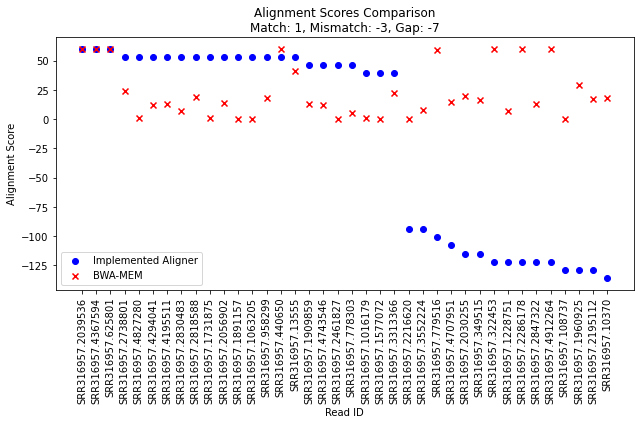

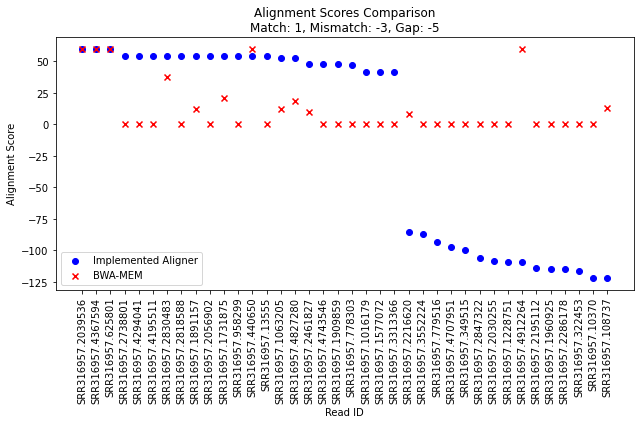

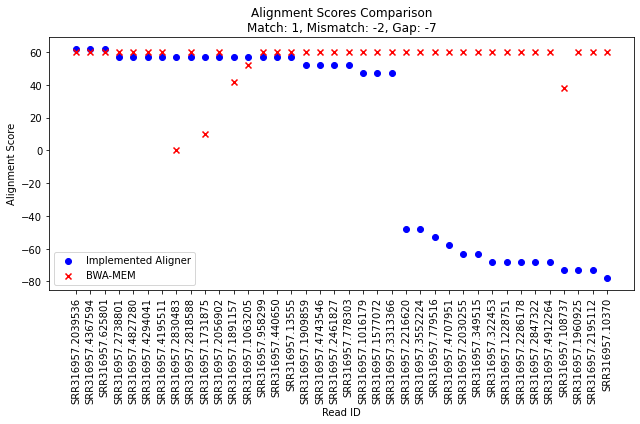

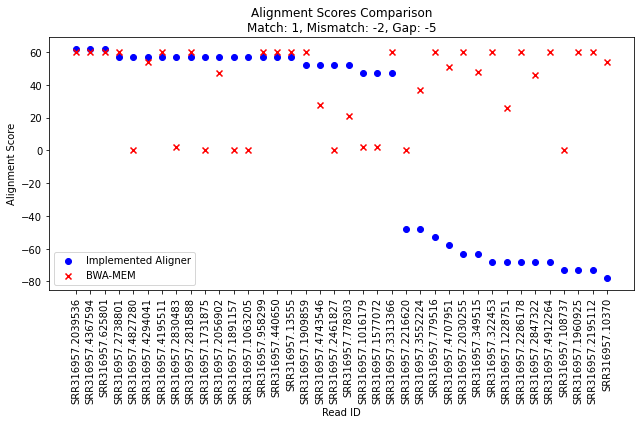

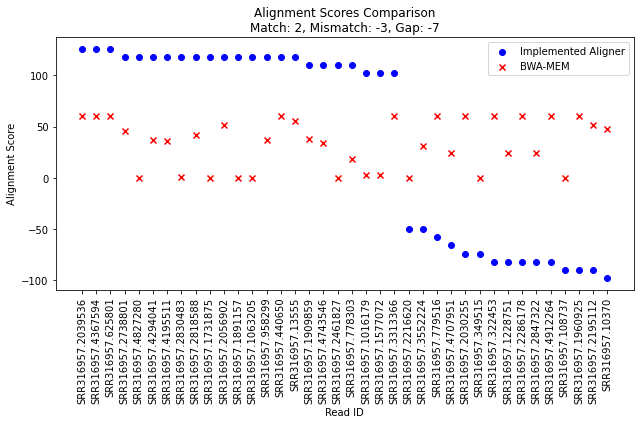

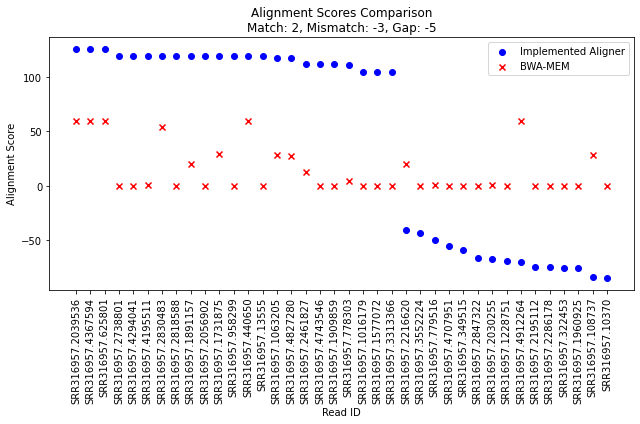

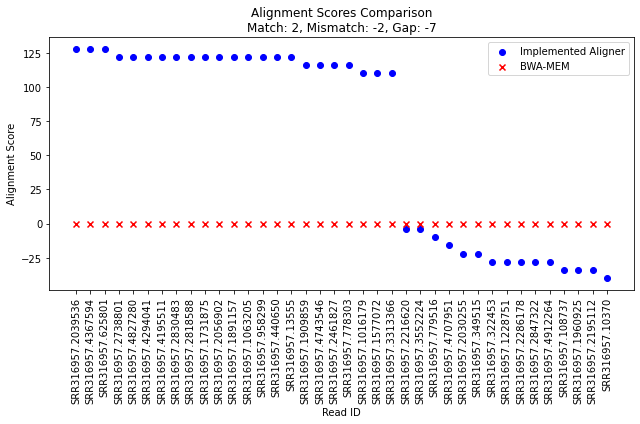

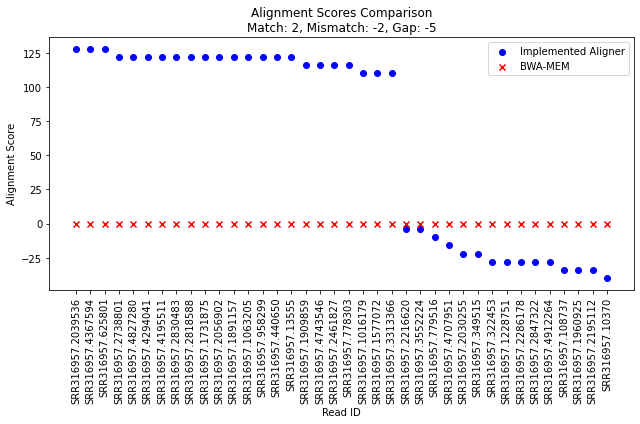

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

matchParameters = [1, 2]
mismatchParameters = [-3, -2]
gapParameters = [-7, -5]

for matchP in matchParameters:
    for mismatchP in mismatchParameters:
        for gapP in gapParameters:
            
            implemented_csv_path = 'results/implementedAligner/output_M{}MM{}G{}.csv'.format(matchP, mismatchP, gapP)
            bwamem_csv_path = 'results/bwamemtool/output_M{}MM{}G{}.csv'.format(matchP, mismatchP, gapP)
            
            dfImplementedAligner = pd.read_csv(implemented_csv_path)
            dfImplementedAligner = dfImplementedAligner.sort_values(by='alignment_score', ascending=False)

            dfBwaMemtool = pd.read_csv(bwamem_csv_path)

            implementedAlignerResultsDf = pd.DataFrame()
            bwamemtoolResultsDf = pd.DataFrame()

            for j in range(len(dfImplementedAligner)): 
                dfRowImplementedAligner = dfImplementedAligner.iloc[j]
                read_id = dfRowImplementedAligner['read_id']
                is_reverse = dfRowImplementedAligner['is_reversed']

                newdfBMT = dfBwaMemtool[(dfBwaMemtool['read_id'] == read_id) & (dfBwaMemtool['is_reversed'] == is_reverse)]
                newdfIA = dfImplementedAligner[(dfImplementedAligner['read_id'] == read_id) & (dfImplementedAligner['is_reversed'] == is_reverse)]

                if not newdfBMT.empty and not newdfIA.empty:
                    bwamemtoolResultsDf = pd.concat([bwamemtoolResultsDf, newdfBMT], ignore_index=True)
                    implementedAlignerResultsDf = pd.concat([implementedAlignerResultsDf, newdfIA], ignore_index=True)

                if len(implementedAlignerResultsDf) >= 100:
                    break  # Exit loop once we have found 20 matches

            # Plotting
            fig, ax = plt.subplots(figsize=(9, 6))

            # Scatter plot for implemented aligner results (Blue)
            ax.scatter(implementedAlignerResultsDf['read_id'], implementedAlignerResultsDf['alignment_score'], color='blue', label='Implemented Aligner', marker='o')

            # Scatter plot for BWA-MEM results (Red)
            ax.scatter(bwamemtoolResultsDf['read_id'], bwamemtoolResultsDf['alignment_score'], color='red', label='BWA-MEM', marker='x')

            # Set labels and title
            ax.set_xlabel('Read ID')
            ax.set_ylabel('Alignment Score')
            ax.set_title('Alignment Scores Comparison\nMatch: {}, Mismatch: {}, Gap: {}'.format(matchP, mismatchP, gapP))
            ax.legend()

            # Rotate x-axis tick labels vertically
            plt.xticks(rotation='vertical')

            # Show plot
            plt.tight_layout()
            plt.show()

In [ ]:
#Read Csv files and plot

import pandas as pd

matchParameters = [1,2]
mismatchParameters = [-3,-2]
gapParameters = [-7,-5]
for matchP in matchParameters:
    for mismatchP in mismatchParameters:
         for gapP in gapParameters:
                dfImplentedAligner = pd.read_csv('results/implementedAligner/output_' + 'M'+str(matchP) +'MM'+ str(mismatchP) +'G'+ str(gapP) + '.csv')
                dfImplentedAligner=dfImplentedAligner.sort_values(by='alignment_score',ascending=False) #sort by alignment score
                #dfImplentedAligner=dfImplentedAligner.head(10)
                dfBwamemtool = pd.read_csv('results/bwamemtool/output_' + 'M'+str(matchP) +'MM'+ str(mismatchP) +'G'+ str(gapP) + '.csv')
                #ax = dfImplentedAligner.plot(kind='scatter', x='read_id', y='alignment_score', figsize=(9,6), color='Blue')
                #dfBwamemtool.plot(ax=ax,kind='scatter', x='read_id', y='alignment_score', figsize=(9,6), color='Red')
                implementedAlignerResultstDf = []
                bwamemtoolResultsDf = pd.DataFrame()

                #print(dfImplentedAligner)
                i=0
                j=0
                while i < 10:
                    dfImplentedAligner = dfImplentedAligner.iloc[[j]]
                    read_id = dfRowImplentedAligner['read_id'].values[0]
                    is_reverse= dfRowImplentedAligner['is_reversed'].values[0]
                    #print(read_id)
                    #bestResults.append((read_id,read.is_reverse,read.reference_start,read.mapping_quality,read.cigarstring)) 
                    newdfBMT=[]
                    newdfBMT = dfBwamemtool[(dfBwamemtool.read_id == read_id) & (dfBwamemtool.is_reversed == is_reverse)]
                    newdfIA = dfRowImplentedAligner[(dfRowImplentedAligner.read_id == read_id) & (dfRowImplentedAligner.is_reversed == is_reverse)]

                    if length(newdfBMT)>0:
                        bwamemtoolResultsDf.append(newdfBMT, ignore_index=True)
                        implementedAlignerResultstDf.append(newdfIA,ignore_index=True)
                        i=i=1
                    j=j+1

                # matchedDfBwaMemtool= pd.DataFrame(bestResults, columns =['read_id', 'is_reversed', 'position','alignment_score','transcript'])
                #dfImplentedAligner.reset_index(drop=True)
                #print(dfImplentedAligner)

                ax = dfImplentedAligner.plot(kind='scatter', x='read_id', y='alignment_score', figsize=(9,6), color='Blue')
                bwamemtoolBestResultsDf.plot(ax=ax,kind='scatter', x='read_id', y='alignment_score', figsize=(9,6), color='Red')
                    

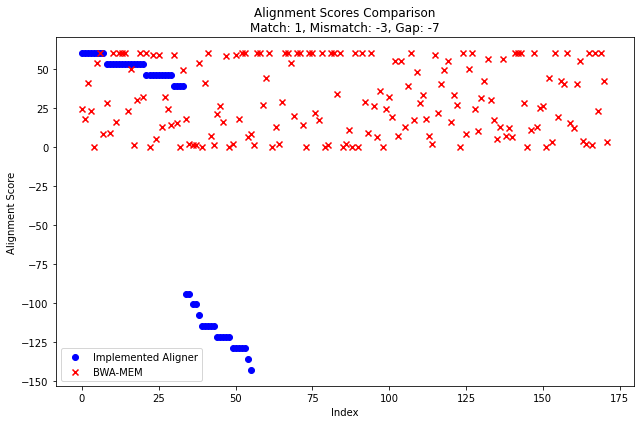

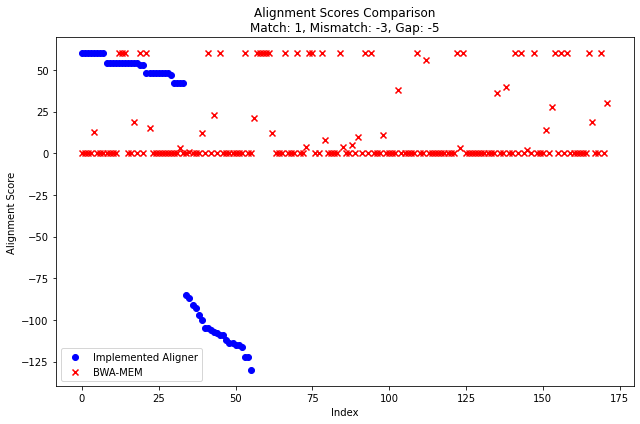

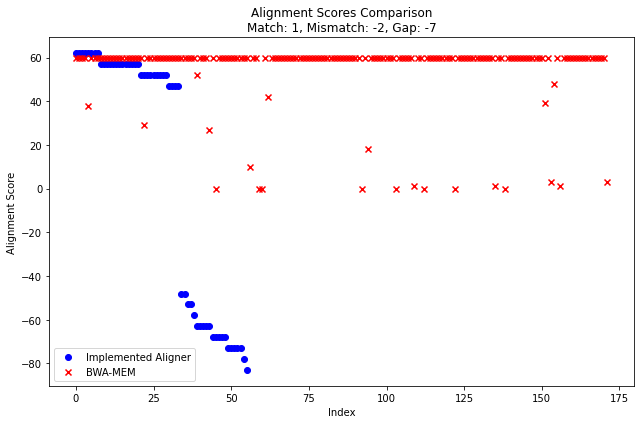

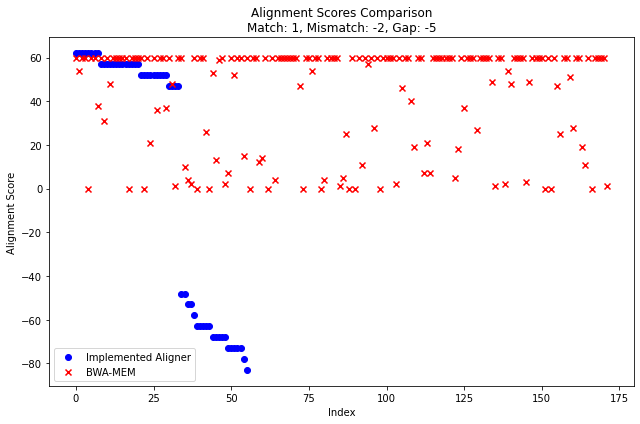

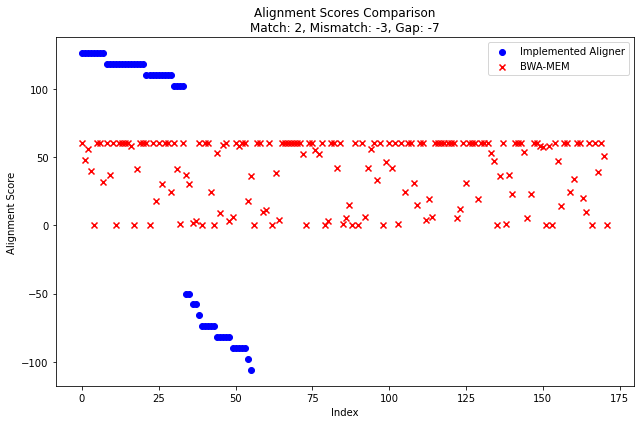

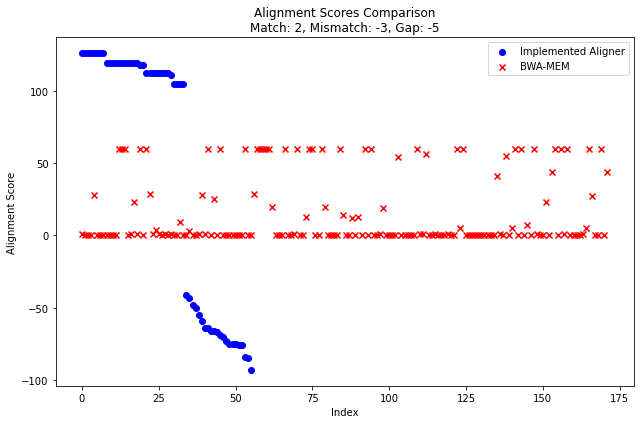

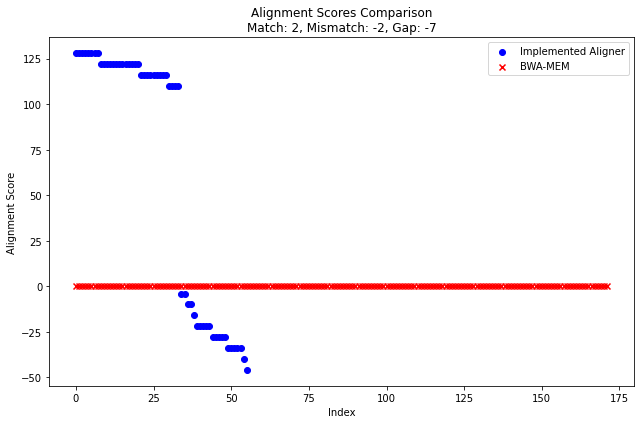

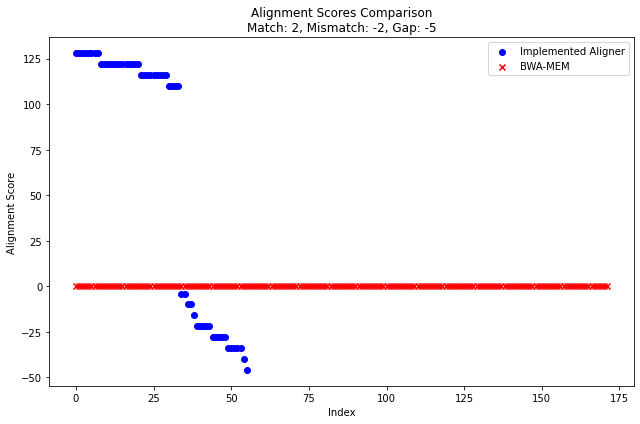

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

matchParameters = [1, 2]
mismatchParameters = [-3, -2]
gapParameters = [-7, -5]

# Define markers for Implemented Aligner and BWA-MEM
implemented_marker = 'o'  # Circle marker
bwamem_marker = 'x'       # Cross marker

for matchP in matchParameters:
    for mismatchP in mismatchParameters:
        for gapP in gapParameters:
            # Read CSV files
            dfImplementedAligner = pd.read_csv('results/implementedAligner/output_' + 'M'+str(matchP) +'MM'+ str(mismatchP) +'G'+ str(gapP) + '.csv')
            dfBwamemtool = pd.read_csv('results/bwamemtool/output_' + 'M'+str(matchP) +'MM'+ str(mismatchP) +'G'+ str(gapP) + '.csv')
            
            # Create the scatter plot
            fig, ax = plt.subplots(figsize=(9, 6))

            # Scatter plot for implemented aligner results (Blue)
            ax.scatter(range(len(dfImplementedAligner)), dfImplementedAligner['alignment_score'], color='blue', label='Implemented Aligner', marker=implemented_marker)

            # Scatter plot for BWA-MEM results (Red)
            ax.scatter(range(len(dfBwamemtool)), dfBwamemtool['alignment_score'], color='red', label='BWA-MEM', marker=bwamem_marker)

            # Set labels and title
            ax.set_xlabel('Index')
            ax.set_ylabel('Alignment Score')
            ax.set_title('Alignment Scores Comparison\nMatch: {}, Mismatch: {}, Gap: {}'.format(matchP, mismatchP, gapP))
            ax.legend()

            # Show plot
            plt.tight_layout()
            plt.show()
